
=== BEST MODEL FOUND ===
Best R2 Score     : 0.898512310710859
Best Learning Rate: 0.01
Best Lambda       : 0

Best Theta:
 [ 0.02088824  0.25796579 -0.3138708   0.89523269  0.09114395  0.36849208
 -0.15762486  0.36301444]


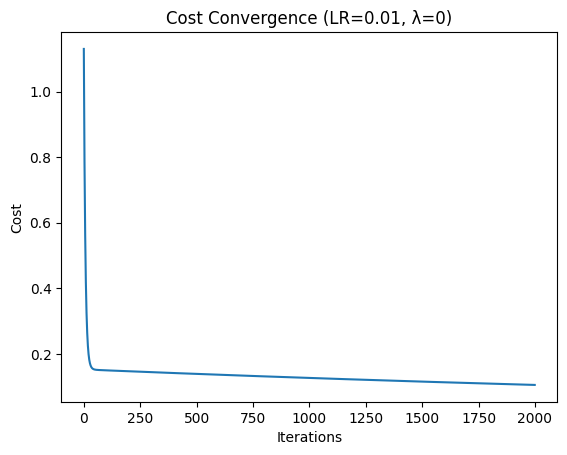

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Step 1: Generate highly correlated dataset
np.random.seed(42)
n_samples = 1000
n_features = 7

X = np.random.randn(n_samples, 1)
for i in range(1, n_features):
    X = np.column_stack([X, X[:, 0] + np.random.randn(n_samples) * 0.1])

beta_true = np.array([2, -3, 4, -1, 0.5, -2, 1])
y = X @ beta_true + np.random.randn(n_samples) * 0.1

# ---- STANDARDIZE FEATURES (VERY IMPORTANT) ----
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add bias
X_train_bias = np.c_[np.ones(X_train.shape[0]), X_train]
X_test_bias = np.c_[np.ones(X_test.shape[0]), X_test]


# Step 2: Ridge Regression Gradient Descent (stable version)
def ridge_cost(X, y, theta, lambda_):
    m = len(y)
    pred = X @ theta
    return (1/(2*m)) * np.sum((pred - y)**2) + (lambda_/2)*np.sum(theta[1:]**2)


def ridge_gradient_descent(X, y, theta, lr, lambda_, num_iter):
    m = len(y)
    cost_hist = []

    for i in range(num_iter):
        pred = X @ theta
        error = pred - y

        gradient = (1/m)*(X.T @ error)
        gradient[1:] += lambda_ * theta[1:]

        # ---- Gradient clipping to prevent divergence ----
        gradient = np.clip(gradient, -10, 10)

        theta = theta - lr * gradient

        cost = ridge_cost(X, y, theta, lambda_)

        # Early stop if cost becomes invalid
        if np.isnan(cost) or np.isinf(cost):
            return None, None

        cost_hist.append(cost)

    return theta, cost_hist


# Step 3: Hyperparameter tuning
learning_rates = [0.0001, 0.001, 0.01]    # removed dangerous large LR
lambdas = [1e-15, 1e-10, 1e-5, 1e-3, 0, 1, 10, 20]

best_r2 = -999
best_lr = None
best_lambda = None
best_theta = None
best_cost_hist = None

for lr in learning_rates:
    for lam in lambdas:

        theta_init = np.zeros(X_train_bias.shape[1])

        theta_opt, cost_hist = ridge_gradient_descent(
            X_train_bias, y_train, theta_init, lr, lam, 2000
        )

        # Skip invalid runs
        if theta_opt is None:
            continue

        y_pred = X_test_bias @ theta_opt

        if np.isnan(y_pred).any():
            continue

        r2 = r2_score(y_test, y_pred)

        if r2 > best_r2:
            best_r2 = r2
            best_lr = lr
            best_lambda = lam
            best_theta = theta_opt
            best_cost_hist = cost_hist


# Step 4: Display results
print("\n=== BEST MODEL FOUND ===")
print(f"Best R2 Score     : {best_r2}")
print(f"Best Learning Rate: {best_lr}")
print(f"Best Lambda       : {best_lambda}")
print("\nBest Theta:\n", best_theta)

# Plot cost curve
plt.plot(best_cost_hist)
plt.title(f"Cost Convergence (LR={best_lr}, λ={best_lambda})")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load the data
# Change the path to where you have saved the CSV
df = pd.read_csv("/content/Hitters.csv", index_col=0)
# The CSV from ISLR has the first column as player name, set as index

# 2. Pre-process the data (a)
#   - Handle null values
print("Before dropna, null counts:\n", df.isna().sum())
df = df.dropna(subset=["Salary"])  # drop rows where Salary is NA
# alternatively drop all NA rows:
df = df.dropna()
print("After dropna, shape:", df.shape)

#   - Encode categorical variables (League, Division, NewLeague)
# League, Division, NewLeague are categorical in ISLR Hitters. :contentReference[oaicite:0]{index=0}
df_encoded = pd.get_dummies(df, columns=["League", "Division", "NewLeague"], drop_first=True)

# 3. Separate input (X) and output (y) (c)
X = df_encoded.drop("Salary", axis=1)
y = df_encoded["Salary"]

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Fit models (Q3)
alpha = 0.5748  # regularization parameter for Ridge and Lasso

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)

# Ridge Regression
ridge_reg = Ridge(alpha=alpha)
ridge_reg.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_reg.predict(X_test_scaled)

# Lasso Regression
lasso_reg = Lasso(alpha=alpha, max_iter=10000)
lasso_reg.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_reg.predict(X_test_scaled)

# 7. Evaluate performance
def print_metrics(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} — MSE: {mse:.2f}, R2: {r2:.3f}")

print_metrics("Linear Regression", y_test, y_pred_lin)
print_metrics("Ridge Regression", y_test, y_pred_ridge)
print_metrics("Lasso Regression", y_test, y_pred_lasso)

# 8. Compare coefficients
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Linear Coef": lin_reg.coef_,
    "Ridge Coef": ridge_reg.coef_,
    "Lasso Coef": lasso_reg.coef_
})
print("\nCoefficients:\n", coef_df)


Before dropna, null counts:
 Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64
After dropna, shape: (263, 19)
Linear Regression — MSE: 138295.31, R2: 0.235
Ridge Regression — MSE: 136924.23, R2: 0.243
Lasso Regression — MSE: 136741.13, R2: 0.244

Coefficients:
         Feature  Linear Coef  Ridge Coef  Lasso Coef
0          Hits   164.756982  157.461322  146.245093
1         HmRun    50.605298   40.791302   29.090971
2          Runs   -76.236909  -63.965119  -53.965986
3           RBI   -65.032264  -53.059031  -41.143799
4         Walks    95.478267   89.943348   85.666909
5         Years    68.446785   32.973993   45.324494
6        CAtBat  -830.183377 -463.183949 -621.598024
7         CHits   368.379603  194.475461  319.6

In [8]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------
# Load the Boston Housing Dataset
# -----------------------------
boston = fetch_openml(name="boston", version=1, as_frame=True)
df = boston.frame

X = df.drop("MEDV", axis=1)   # Input features
y = df["MEDV"]                # Output variable (House price)

# -----------------------------
# Train-Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# Scaling
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# RidgeCV (Cross-Validated Ridge Regression)
# -----------------------------
alphas = np.logspace(-3, 3, 50)  # Range of regularization strengths

ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train_scaled, y_train)

ridge_pred = ridge_cv.predict(X_test_scaled)

# -----------------------------
# LassoCV (Cross-Validated Lasso Regression)
# -----------------------------
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=50000)
lasso_cv.fit(X_train_scaled, y_train)

lasso_pred = lasso_cv.predict(X_test_scaled)

# -----------------------------
# Performance Comparison
# -----------------------------
def evaluate(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Results:")
    print(f"  MSE : {mse:.4f}")
    print(f"  R2  : {r2:.4f}\n")

evaluate("RidgeCV", y_test, ridge_pred)
evaluate("LassoCV", y_test, lasso_pred)

# Show best alphas selected
print("Best Ridge Alpha:", ridge_cv.alpha_)
print("Best Lasso Alpha:", lasso_cv.alpha_)


RidgeCV Results:
  MSE : 24.3494
  R2  : 0.6680

LassoCV Results:
  MSE : 24.2945
  R2  : 0.6687

Best Ridge Alpha: 2.6826957952797246
Best Lasso Alpha: 0.001


In [10]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# ------------------------------------------------------------
# 1. Load Iris Dataset
# ------------------------------------------------------------
iris = load_iris()
X = iris.data                      # shape (150,4)
y = iris.target                    # classes: 0,1,2

# ------------------------------------------------------------
# 2. Train-Test Split
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# 3. Scaling Features
# ------------------------------------------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------------------------------------------------
# 4. Helper Functions
# ------------------------------------------------------------

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function
def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    h = np.clip(h, 1e-10, 1 - 1e-10)  # numerical stability
    cost = -(1/m) * (y*np.log(h) + (1-y)*np.log(1-h)).sum()
    return cost

# Gradient descent
def gradient_descent(X, y, theta, lr, iters):
    m = len(y)
    cost_history = []

    for _ in range(iters):
        h = sigmoid(X @ theta)
        grad = (1/m) * (X.T @ (h - y))
        theta -= lr * grad
        cost_history.append(compute_cost(X, y, theta))

    return theta, cost_history


class LogisticOVR:
    def __init__(self, lr=0.1, iters=2000):
        self.lr = lr
        self.iters = iters

    def fit(self, X, y):
        self.classes = np.unique(y)
        m, n = X.shape

        # Add bias column
        X_bias = np.c_[np.ones((m, 1)), X]

        # Train 1 classifier per class
        self.thetas = []

        for cls in self.classes:
            print(f"Training classifier for class {cls} vs rest...")

            # Create binary labels: 1 for class cls, 0 otherwise
            y_binary = (y == cls).astype(int)

            theta = np.zeros(n + 1)
            theta, _ = gradient_descent(X_bias, y_binary, theta, self.lr, self.iters)

            self.thetas.append(theta)

        self.thetas = np.array(self.thetas)

    def predict(self, X):
        m = X.shape[0]
        X_bias = np.c_[np.ones((m, 1)), X]

        probs = sigmoid(X_bias @ self.thetas.T)   # shape (m,3)

        return np.argmax(probs, axis=1)



model = LogisticOVR(lr=0.1, iters=5000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("\nPredicted:", y_pred)
print("Actual:   ", y_test)
print(f"\nAccuracy: {acc * 100:.2f}%")


Training classifier for class 0 vs rest...
Training classifier for class 1 vs rest...
Training classifier for class 2 vs rest...

Predicted: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]
Actual:    [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]

Accuracy: 100.00%
